In [8]:
import pandas as pd
import requests
from datetime import datetime

# Load data from the API
url = "https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date=2023-01-01&end_date=2023-01-31&daily=sunrise,sunset&hourly=temperature_2m,relative_humidity_2m,snowfall,rain,wind_speed_10m"
response = requests.get(url)
data = response.json()

# Create hourly dataframe
hourly_df = pd.DataFrame({
    'time': pd.to_datetime(data['hourly']['time']),
    'temperature_2m': data['hourly']['temperature_2m'],
    'relative_humidity_2m': data['hourly']['relative_humidity_2m'],
    'snowfall': data['hourly']['snowfall'],
    'rain': data['hourly']['rain'],
    'wind_speed_10m': data['hourly']['wind_speed_10m']
})

# Create daily dataframe for sunrise/sunset
daily_df = pd.DataFrame({
    'date': pd.to_datetime(data['daily']['time']),
    'sunrise': pd.to_datetime(data['daily']['sunrise']),
    'sunset': pd.to_datetime(data['daily']['sunset'])
})

# Merge hourly data with daily sunrise/sunset
hourly_df['date'] = hourly_df['time'].dt.date
daily_df['date'] = daily_df['date'].dt.date
merged_df = hourly_df.merge(daily_df, on='date', how='left')

# Create dark/light column (dark if time is before sunrise or after sunset)
merged_df['period'] = merged_df.apply(
    lambda row: 'dark' if row['time'] < row['sunrise'] or row['time'] >= row['sunset'] else 'light',
    axis=1
)

# Select final columns
result_df = merged_df[['time', 'temperature_2m', 'relative_humidity_2m', 'snowfall', 'rain', 'wind_speed_10m', 'period']]

# Save to parquet
result_df.to_parquet('weather_data.parquet', index=False)
print(f"Data saved to weather_data.parquet with {len(result_df)} records")

Data saved to weather_data.parquet with 744 records


In [11]:
# Redefine the period column based on fixed times (16:30 - 7:30 is dark, rest is light)
result_df['hour_minute'] = result_df['time'].dt.hour + result_df['time'].dt.minute / 60
result_df['period'] = result_df['hour_minute'].apply(
    lambda x: 'dark' if x >= 16.5 or x < 7.5 else 'light'
)
result_df = result_df.drop('hour_minute', axis=1)

# Save to parquet
result_df.to_parquet('weather_data.parquet', index=False)
print(f"Data updated with fixed dark/light periods and saved to weather_data.parquet with {len(result_df)} records")

Data updated with fixed dark/light periods and saved to weather_data.parquet with 744 records


/var/folders/x1/38d_8dr16cb7x2w_3j50cjvr0000gn/T/ipykernel_13358/2015981697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['hour_minute'] = result_df['time'].dt.hour + result_df['time'].dt.minute / 60
/var/folders/x1/38d_8dr16cb7x2w_3j50cjvr0000gn/T/ipykernel_13358/2015981697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['period'] = result_df['hour_minute'].apply(


In [12]:
df = pd.read_parquet('weather_data.parquet')
df

,time,temperature_2m,relative_humidity_2m,snowfall,rain,wind_speed_10m,period
0,2023-01-01 00:00:00,8.7,100,0.0,0.4,11.3,dark
1,2023-01-01 01:00:00,10.8,100,0.0,1.1,10.4,dark
2,2023-01-01 02:00:00,10.8,100,0.0,0.8,9.3,dark
3,2023-01-01 03:00:00,10.9,99,0.0,1.9,11.5,dark
4,2023-01-01 04:00:00,10.6,99,0.0,1.0,11.3,dark
...,...,...,...,...,...,...,...
739,2023-01-31 19:00:00,4.0,47,0.0,0.0,11.3,dark
740,2023-01-31 20:00:00,4.2,41,0.0,0.0,13.4,dark
741,2023-01-31 21:00:00,3.6,36,0.0,0.0,13.5,dark
742,2023-01-31 22:00:00,3.0,38,0.0,0.0,10.9,dark


/var/folders/x1/38d_8dr16cb7x2w_3j50cjvr0000gn/T/ipykernel_13358/4119294557.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_numeric = pivot_data.replace({'dark': 0, 'light': 1})


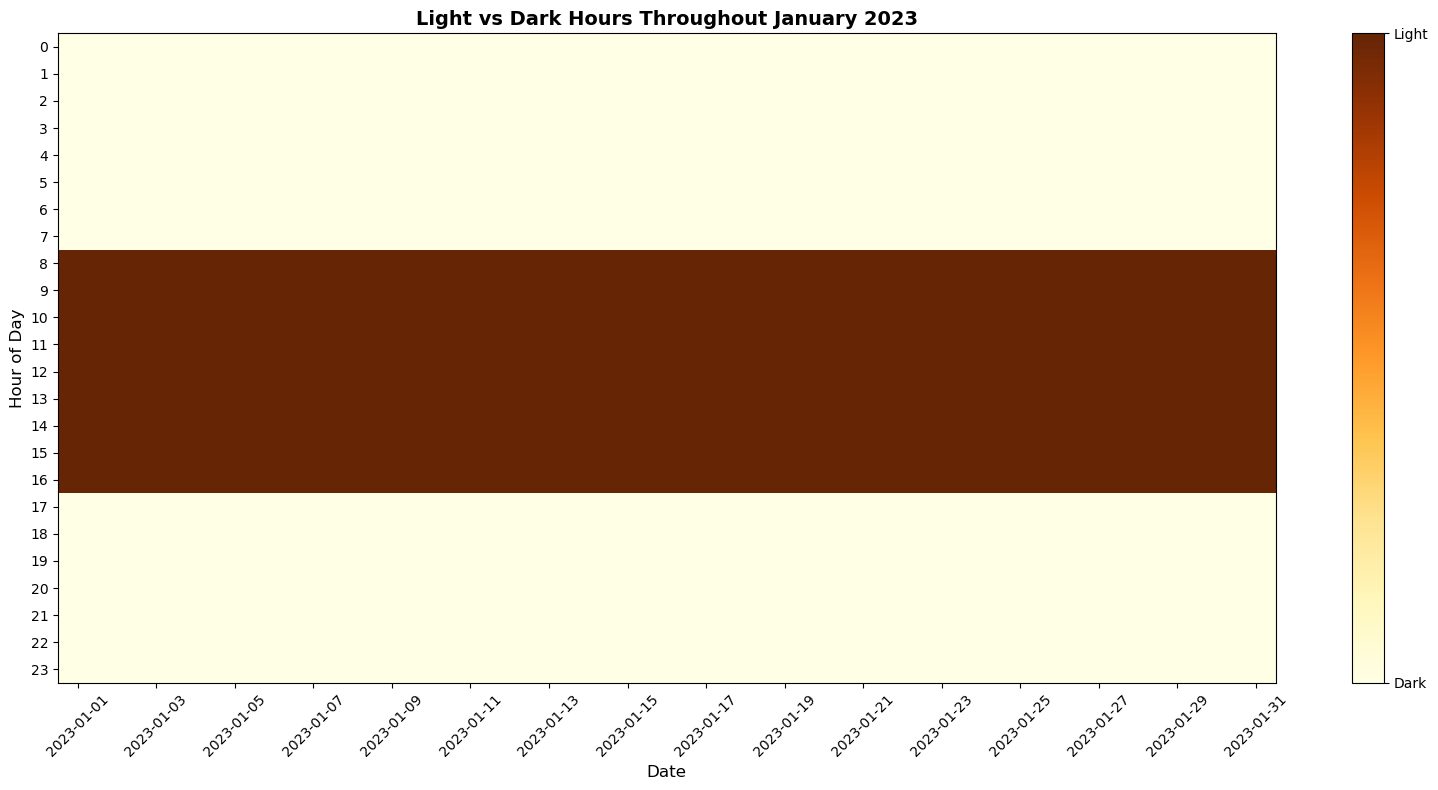

In [13]:
import numpy as np

import matplotlib.pyplot as plt

# Create a pivot table with hour of day vs date
df['hour'] = df['time'].dt.hour
df['date_only'] = df['time'].dt.date

pivot_data = df.pivot_table(index='hour', columns='date_only', values='period', aggfunc='first')

# Convert to numeric (0 for dark, 1 for light)
pivot_numeric = pivot_data.replace({'dark': 0, 'light': 1})

# Create heatmap
fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(pivot_numeric, cmap='YlOrBr', aspect='auto', interpolation='nearest')

# Set labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Hour of Day', fontsize=12)
ax.set_title('Light vs Dark Hours Throughout January 2023', fontsize=14, fontweight='bold')

# Set ticks
ax.set_yticks(range(24))
ax.set_yticklabels(range(24))
ax.set_xticks(range(0, len(pivot_numeric.columns), 2))
ax.set_xticklabels([str(pivot_numeric.columns[i]) for i in range(0, len(pivot_numeric.columns), 2)], rotation=45)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['Dark', 'Light'])

plt.tight_layout()
plt.show()